# Advanced Yield Curve Analysis with PCA and Dynamic Factor Modeling

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

In [46]:
# Set aesthetic parameters
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

## 1. Simulate yield curve data (10 maturities over 5 years)

In [47]:
np.random.seed(42)
maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
dates = pd.date_range('2018-01-01', '2023-01-01', freq='ME')
n_periods = len(dates)

In [48]:
# Nelson-Siegel model for yield curve dynamics
def nelson_siegel(t, beta0, beta1, beta2, tau):
    return beta0 + beta1*(1-np.exp(-t/tau))/(t/tau) + beta2*((1-np.exp(-t/tau))/(t/tau)-np.exp(-t/tau))

In [49]:
# Generate synthetic yield curves with macroeconomic shocks
beta0 = np.random.normal(loc=0.03, scale=0.01, size=n_periods)
beta1 = np.random.normal(loc=-0.02, scale=0.005, size=n_periods)
beta2 = np.random.normal(loc=0.01, scale=0.003, size=n_periods)
tau = 2.0

yield_curves = np.zeros((n_periods, len(maturities)))
for i in range(n_periods):
    yield_curves[i] = nelson_siegel(maturities, beta0[i], beta1[i], beta2[i], tau)

In [50]:
# Add noise and macroeconomic shocks
recession_periods = [24, 25, 26, 48, 49]
inflation_shocks = [12, 13, 36, 37]
yield_curves[recession_periods] += np.random.normal(-0.015, 0.002, (len(recession_periods), len(maturities)))
yield_curves[inflation_shocks] += np.random.normal(0.02, 0.003, (len(inflation_shocks), len(maturities)))
yield_curves += np.random.normal(0, 0.001, yield_curves.shape)


## 2. Compute daily changes and covariance matrix

In [51]:
daily_changes = np.diff(yield_curves, axis=0)
cov_matrix = np.cov(daily_changes, rowvar=False)


## 3. Perform PCA

In [52]:
pca = PCA()
principal_components = pca.fit_transform(daily_changes)

## 4. Create interactive yield curve visualization

In [53]:
fig = go.Figure()
for i in range(0, len(dates)-1, 5):
    fig.add_trace(go.Scatter(
        x=maturities, 
        y=yield_curves[i],
        mode='lines',
        name=str(dates[i].date()),
        visible=False
    ))
fig.update_layout(
    title='Yield Curve Evolution (2018-2023)',
    xaxis_title='Maturity (Years)',
    yaxis_title='Yield',
    sliders=[{
        'steps': [{
            'method': 'update',
            'label': str(dates[i].date()),
            'args': [{'visible': [j==i//5 for j in range(len(fig.data))]}]
        } for i in range(0, len(dates)-1, 5)]
    }]
)
fig.show()                  

##  5. 3D PCA Visualization

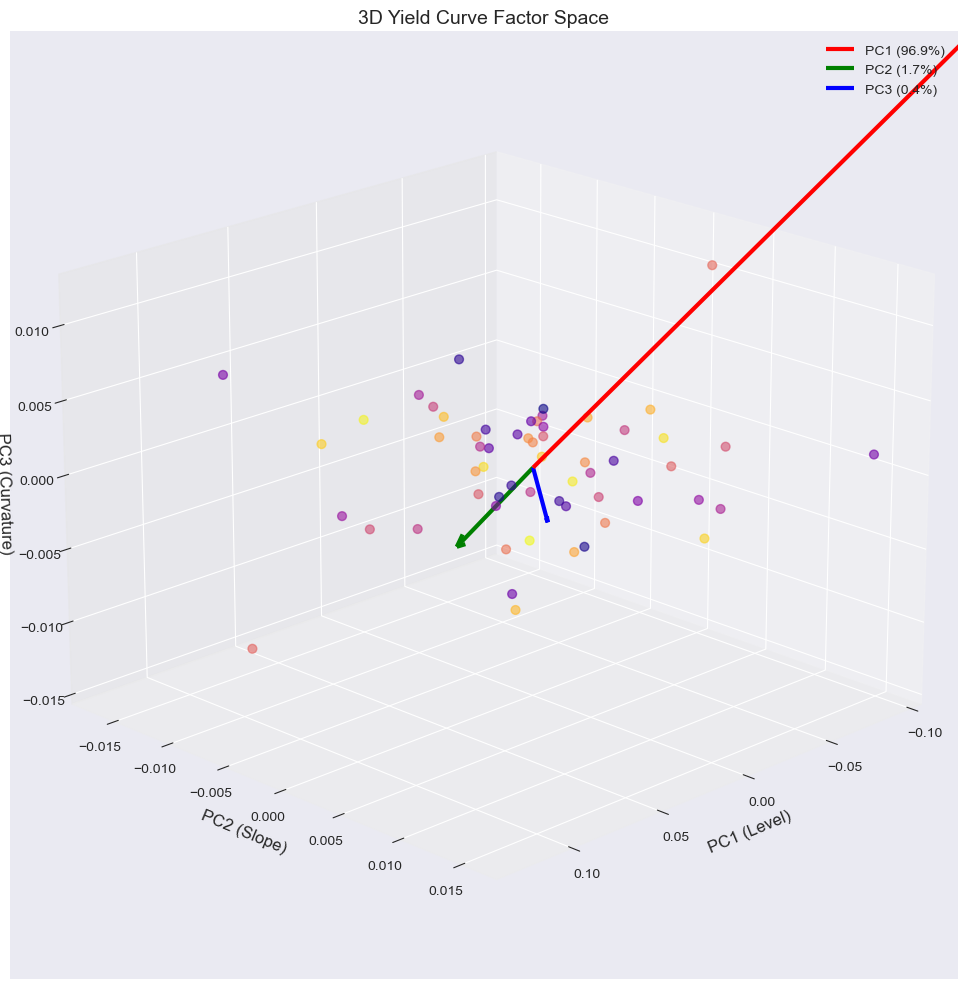

In [54]:
plt.figure(figsize=(12, 10))
ax = plt.axes(projection='3d')  
colors = cm.plasma(np.linspace(0, 1, len(principal_components)))
ax.scatter(principal_components[:, 0], 
           principal_components[:, 1], 
           principal_components[:, 2],
           c=colors, s=40, alpha=0.6)

eigenvectors = pca.components_[:3]
for i, (vec, var) in enumerate(zip(eigenvectors, pca.explained_variance_)):
    scale = 3 * np.sqrt(var)
    
    ax.quiver(0, 0, 0,
              vec[0]*scale, vec[1]*scale, vec[2]*scale,
              color=['red', 'green', 'blue'][i],
              arrow_length_ratio=0.1,
              linewidth=3,
              label=f'PC{i+1} ({pca.explained_variance_ratio_[i]:.1%})')

ax.set_xlabel('PC1 (Level)', fontsize=12)
ax.set_ylabel('PC2 (Slope)', fontsize=12)
ax.set_zlabel('PC3 (Curvature)', fontsize=12)
ax.set_title('3D Yield Curve Factor Space', fontsize=14)

ax.legend(loc='upper right')

ax.view_init(elev=20, azim=45)

plt.tight_layout()

plt.show()

## 6. Variance explained visualization

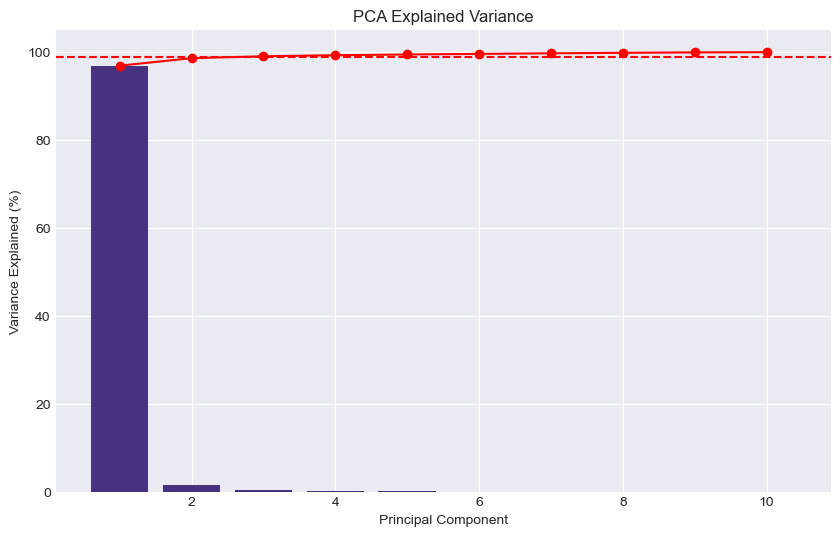

In [55]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), pca.explained_variance_ratio_[:10]*100)
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_[:10])*100, 'ro-')
plt.axhline(y=99, color='r', linestyle='--')
plt.title('PCA Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.grid(True)
plt.show()

## 7. Factor Loading Analysis

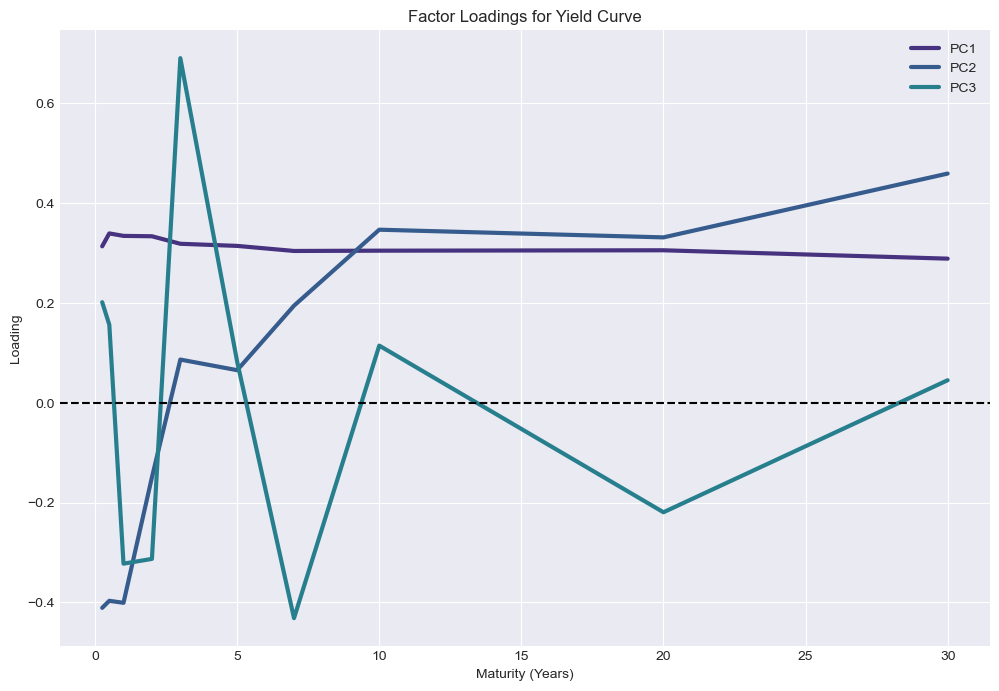

In [56]:
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.plot(maturities, pca.components_[i], label=f'PC{i+1}', linewidth=3)

plt.axhline(y=0, color='k', linestyle='--')
plt.title('Factor Loadings for Yield Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Loading')
plt.legend()
plt.grid(True)

## 8. Animated Yield Curve Decomposition

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0.25, 30)
ax.set_ylim(-0.02, 0.06)
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Yield Change')
ax.set_title('Yield Curve Decomposition')
ax.grid(True)

line_original, = ax.plot([], [], 'b-', label='Original', linewidth=2)
line_level, = ax.plot([], [], 'r-', label='Level Factor', linewidth=2)
line_slope, = ax.plot([], [], 'g-', label='Slope Factor', linewidth=2)
line_curvature, = ax.plot([], [], 'm-', label='Curvature Factor', linewidth=2)
line_recon, = ax.plot([], [], 'k--', label='Reconstructed', linewidth=2)
ax.legend(loc='upper right')

def init():
    for line in [line_original, line_level, line_slope, line_curvature, line_recon]:
        line.set_data([], [])
    return (line_original, line_level, line_slope, line_curvature, line_recon)

def animate(i):
    i = min(i, len(daily_changes)-1)
    
    change = daily_changes[i]
    line_original.set_data(maturities, change)
    
    level = principal_components[i, 0] * pca.components_[0]
    slope = principal_components[i, 1] * pca.components_[1]
    curvature = principal_components[i, 2] * pca.components_[2]
    recon = level + slope + curvature
    
    line_level.set_data(maturities, level)
    line_slope.set_data(maturities, slope)
    line_curvature.set_data(maturities, curvature)
    line_recon.set_data(maturities, recon)
    
    ax.set_title(f'Yield Curve Decomposition - Day {i+1}')
    
    return (line_original, line_level, line_slope, line_curvature, line_recon)

ani = FuncAnimation(fig, animate, frames=min(100, len(daily_changes)),
                   init_func=init, blit=True, interval=200)

plt.close() 
HTML(ani.to_jshtml())  


## 9. Metrics Table

In [58]:
metrics = pd.DataFrame({
    'Factor': ['Level', 'Slope', 'Curvature', 'Remaining'],
    'Variance Explained (%)': [
        pca.explained_variance_ratio_[0]*100,
        pca.explained_variance_ratio_[1]*100,
        pca.explained_variance_ratio_[2]*100,
        (1 - np.sum(pca.explained_variance_ratio_[:3]))*100
    ],
    'Cumulative Variance (%)': [
        pca.explained_variance_ratio_[0]*100,
        np.sum(pca.explained_variance_ratio_[:2])*100,
        np.sum(pca.explained_variance_ratio_[:3])*100,
        100
    ]
})
print(metrics)

      Factor  Variance Explained (%)  Cumulative Variance (%)
0      Level               96.930126                96.930126
1      Slope                1.705340                98.635466
2  Curvature                0.432466                99.067932
3  Remaining                0.932068               100.000000
